# Implementing $\pi_{\rm int} + \pi_{\rm OU}$ on the semi-circle
Simulation of agent following pheromone along a semi-circle connecting points A and B for a given distance/angle followed by exploration under OU policy. The agent lays pheromone on the way back if it succeeds in reaching Point B.
## TOC:
* [Single agent learning using epsilon-greedy policy](#first-bullet)

In [109]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
import matplotlib.patheffects as path_effects

import importlib
# Function for plots
import plotFns as pF
# Parameters in the model
import prmts as pR

In [121]:
global colors
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="first-bullet">Single agent learning using epsilon-greedy policy</a>
 Agent updates its estimate of value function using $\epsilon$-greedy strategy

In [111]:
# Pheromone initial condition and class
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

In [112]:
# Agent class
class agent():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent
        self.valFn = np.zeros(p.nPtn) #value function initialized to zero
        self.phiSc = 0. #Angle at which bifurcation happens
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        if np.linalg.norm(self.r - p.tgt) < p.sigma:
            self.rwd += (np.pi - self.phiSc)*p.a
            self.sInd = p.nSteps
        if np.linalg.norm(self.r) > (p.a+p.pt+0.1):
            self.sInd = p.nSteps
        # self.valFn[iVal[0][-1]] = (self.valFn[iVal[0][-1]]+self.rwd)*0.5
        # self.thet = self.thet*(1-p.l) + p.l*p.tgtPhi + np.sqrt(2*p.pe*p.l)*np.random.normal()
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent

--- 0.050952911376953125 seconds ---


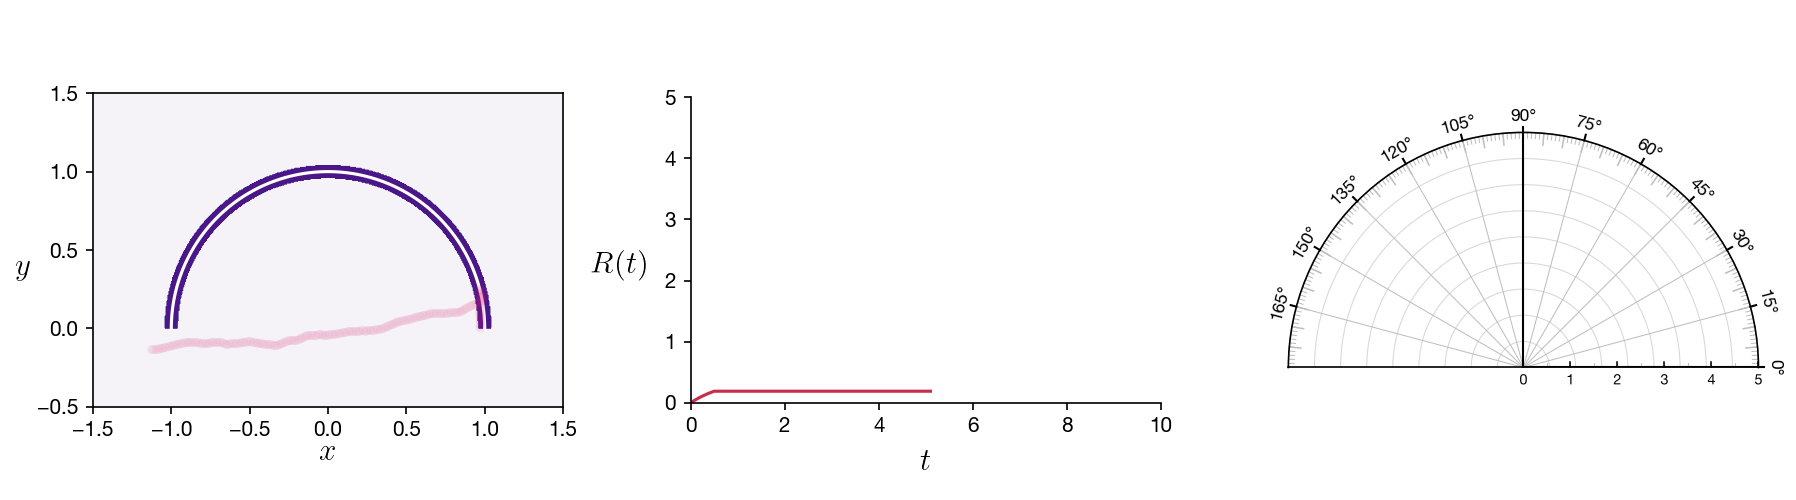

In [113]:
import importlib
importlib.reload(pR)
# Simple 1-epoch run
p = pR.params()
ag = agent(p)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
# thetFull = np.array(p.thetInit)
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
rwdFull = np.array(0.0)
while ag.sInd <= p.nSteps:
    if ag.sInd < p.nSc:
        ag.intPolicy(p)
    elif ag.sInd == p.nSc:
        tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
        p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
        # p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
        p.diff = p.diffCst/np.arctan2(ag.r[1],ag.r[0])
        ag.ouPolicy(p)
    else:
        ag.ouPolicy(p)
    ag.sTrl += p.l
    ag.sInd += 1
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
    rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
print("--- %s seconds ---" % (time.time() - start_time))

import importlib
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn, 10.)
plt.show()

In [47]:
! rm Single*.png

In [48]:
importlib.reload(pF)
importlib.reload(pR)

pF.plotVidFn(p, xphm, yphm, phm, rxFull, ryFull, phxFull, phyFull, rwdFull)

In [ ]:
! ffmpeg -r 10 -i "Single%d.png" -c:v libx264 -vf fps=20 -pix_fmt yuv420p ./SingleTD.mp4

### Agent following $\epsilon$-greedy policy
Agent estimates the value function $v(s_c)$ using TD(0)-learning algorithm for `p.nEpchs`

/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_10142/4146544116.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  p.diff = p.diffCst/np.arctan2(ag.r[1],ag.r[0])
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_10142/4146544116.py:47: RuntimeWarning: invalid value encountered in cos
  phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_10142/4146544116.py:48: RuntimeWarning: invalid value encountered in sin
  phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_10142/3434556053.py:32: RuntimeWarning: invalid value encountered in cos
  self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_10142/3434556053.py:32: RuntimeWarning: invalid value encountered in sin
  self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
/var/folders/hq/qfn7h8h16pvdp9

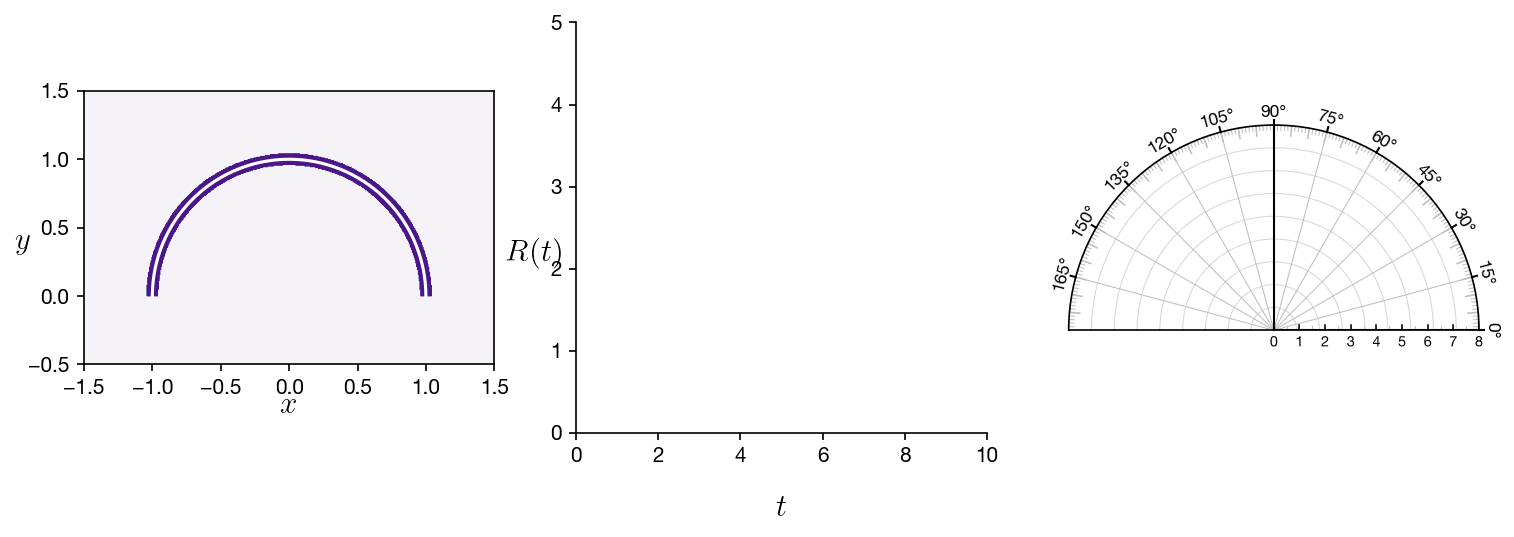

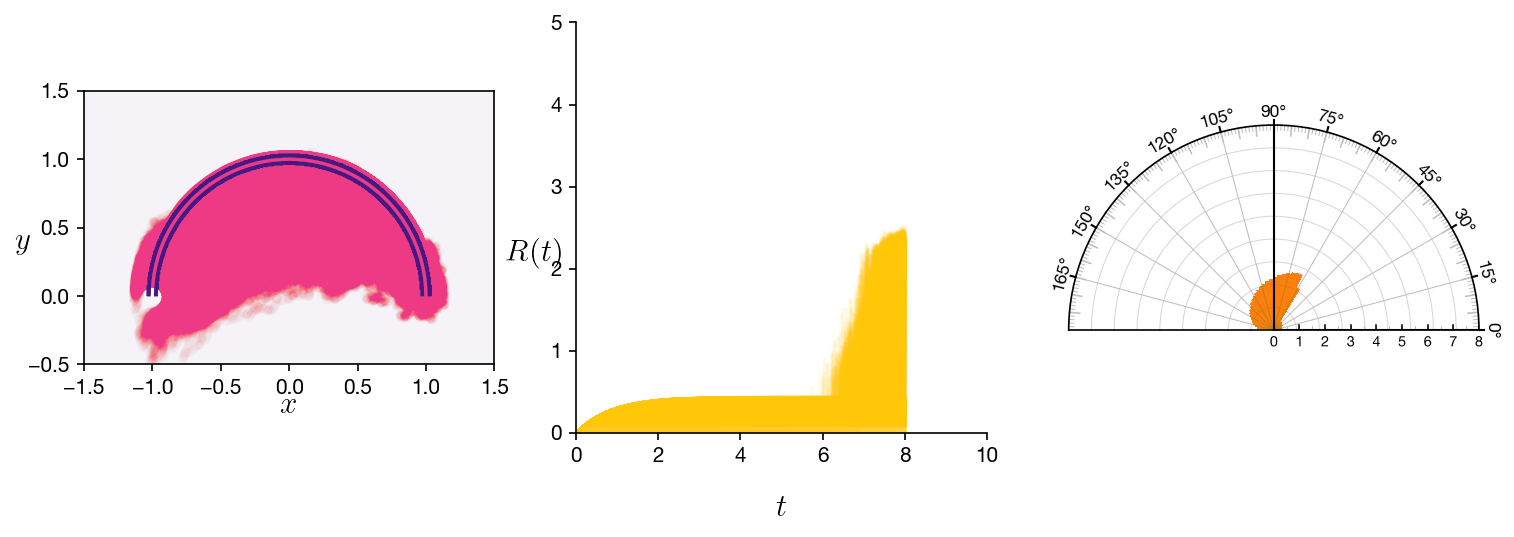

--- 628.2161657810211 seconds ---


In [7]:
#Don't run this one
importlib.reload(pF)
importlib.reload(pR)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
fix, ax = pF.plotDef(8, p, xphm, yphm, phm)

start_time = time.time()
p = pR.params()
ag = agent(p)

# for eInd in range(200):
for eInd in range(p.nEpchs):
    p = pR.params()
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
    #High exploration in beginning and exploitation later
    #High weight for reward in beginning and small later
    if eInd >= 1000:
        p.epsilon = 0.1
        p.alpha = 0.1
    if (np.random.uniform() < p.epsilon) or (eInd < 100):
        p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
    else:
        iVmax = np.argmax(ag.valFn)
        p.nSc =  phiPtn[iVmax]//p.l
    # print(p.nSc)
    while ag.sInd <= p.nSteps:
        if ag.sInd < p.nSc:
            ag.intPolicy(p)
        elif ag.sInd == p.nSc:
            #Orientation of the target from given location
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r)
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            #Diffusion as a function of \phi_c or equivalently s_c
            ag.phiSc = np.arctan2(ag.r[1], ag.r[0])
            # p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
            p.diff = p.diffCst/np.arctan2(ag.r[1],ag.r[0])
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
        ag.sTrl += p.l
        ag.sInd += 1
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
    iVal = np.where(phiPtn <= ag.phiSc)

    #TD(0)-learning value function update rule
    # ag.valFn[iVal[0][-1]] = (ag.valFn[iVal[0][-1]] + ag.rwd)*0.5
    ag.valFn[iVal[0][-1]] = ag.valFn[iVal[0][-1]]*(1 - p.alpha) + ag.rwd*p.alpha
    ag.reset(p)
    pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn, 1.0)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))


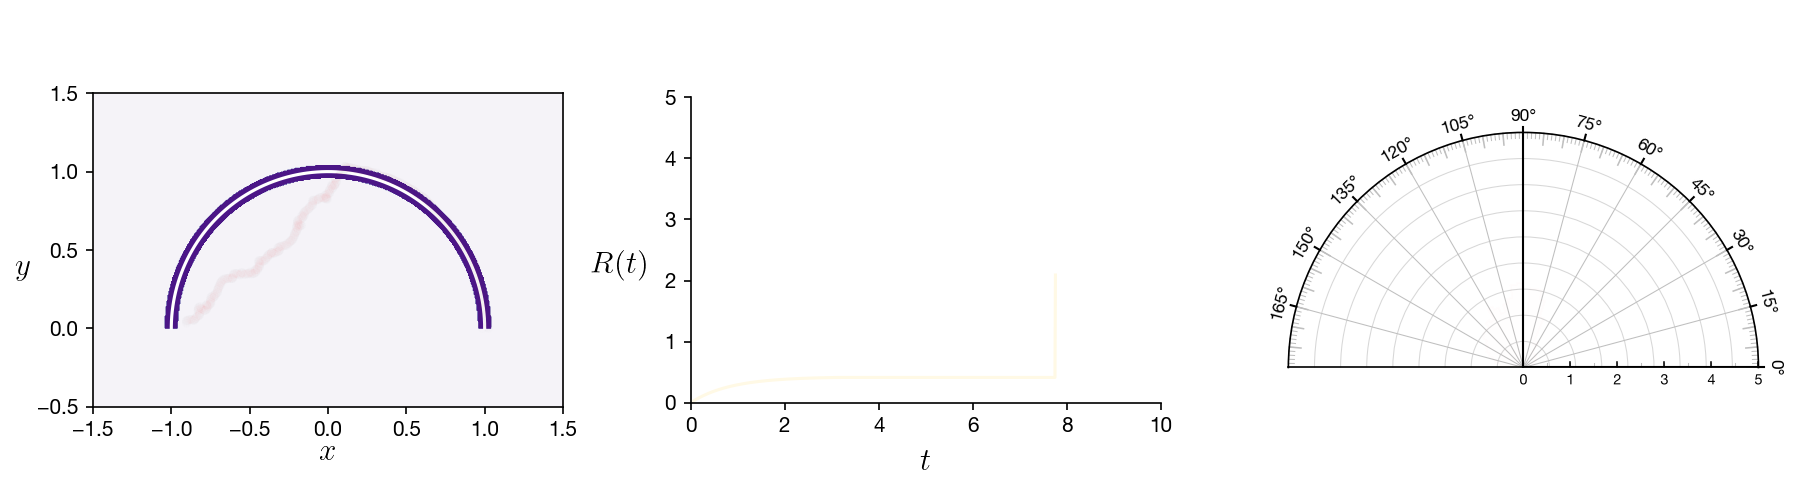

In [24]:
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn, 1)
plt.show()

Value function, $v(\phi)$ vs polar angle, $\phi$ after the last epoch

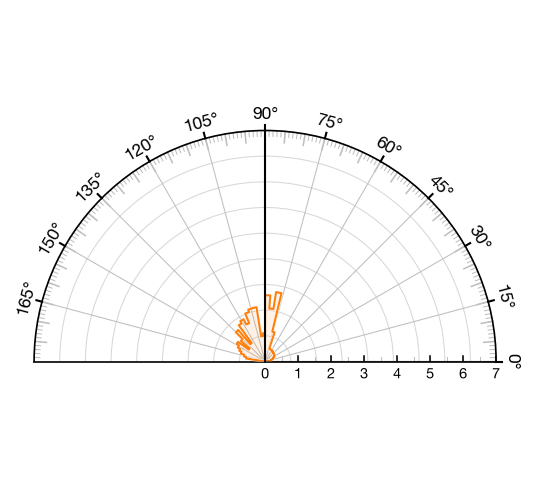

In [8]:
import importlib
importlib.reload(pF)
fig, ax = pF.plotRadial(7, p, ag.valFn)
plt.show()

Generate video to see the evolution of $v(s_c)$

In [114]:
importlib.reload(pF)
importlib.reload(pR)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
start_time = time.time()

p = pR.params()
ag = agent(p)
fix, ax = pF.plotDef(3, p, xphm, yphm, phm)
imInd = 0
valAvg = np.zeros(p.nPtn) #Average of value function
# for eInd in range(1,1000):
for eInd in range(p.nEpchs):
    
    p = pR.params()
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
    
    if eInd >= 3000:
        p.epsilon = 1.1-eInd/p.nEpchs
        p.alpha = 0.1
        valAvg += ag.valFn/(p.nEpchs-3000)
        
    if (np.random.uniform() < p.epsilon):
        p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
    else:
        iVmax = np.argmax(ag.valFn)
        p.nSc =  phiPtn[iVmax]//p.l
        
    while ag.sInd <= p.nSteps:
        if ag.sInd < p.nSc:
            ag.intPolicy(p)
        elif ag.sInd == p.nSc:
            #Orientation of the target from given location
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r)
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            #Diffusion as a function of \phi_c or equivalently s_c
            ag.phiSc = np.arctan2(ag.r[1], ag.r[0])
            # p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
            p.diff = p.diffCst/(np.arctan2(ag.r[1],ag.r[0])+.01)
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
            
        ag.sTrl += p.l
        ag.sInd += 1
        
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
    
    iVal = np.where(phiPtn <= ag.phiSc)
    
    #TD(0)-learning value function update rule
    ag.valFn[iVal[0][-1]] = ag.valFn[iVal[0][-1]]*(1 - p.alpha) + ag.rwd*p.alpha
    
    #Reset agent to initial location
    ag.reset(p)
    pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn, 1.0)
    
    if (eInd%100) == 0:
        plt.tight_layout()
        plt.savefig("Inter"+str(imInd)+".png")
        plt.close()
        fix, ax = pF.plotDef(3, p, xphm, yphm, phm)
        imInd += 1
        
# plt.show()
print("--- %s seconds ---" % (time.time() - start_time))


--- 500.06975078582764 seconds ---


In [116]:
! rm Inter*.png

In [115]:
! rm TDLearning.mp4
! ffmpeg -r 10 -i "Inter%d.png" -c:v libx264 -vf fps=5 -pix_fmt yuv420p ./TDLearning.mp4
#! rm *.png

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

Average of the value function, $\mathbb{E} [v(\phi)]$ vs $\phi$ that the agent learns

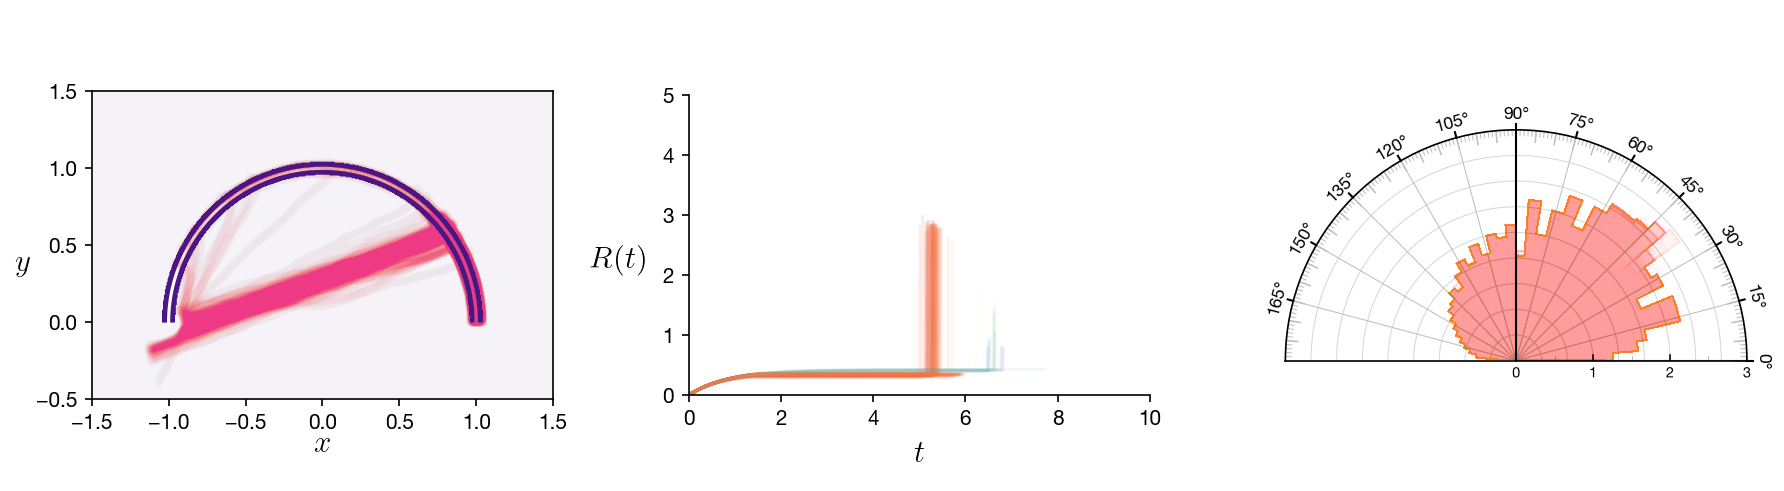

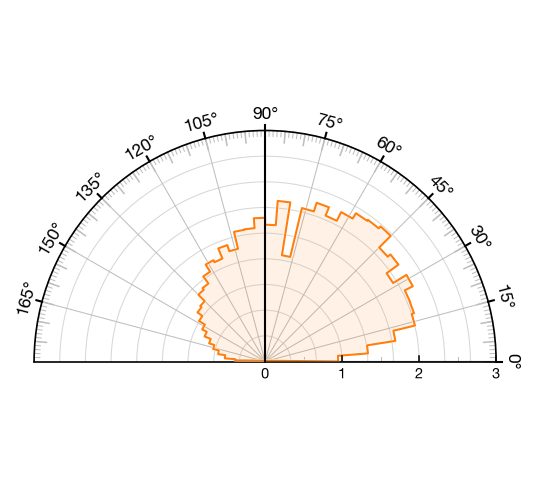

In [117]:
import importlib
importlib.reload(pF)
fig, ax = pF.plotRadial(3, p, valAvg)
plt.show()

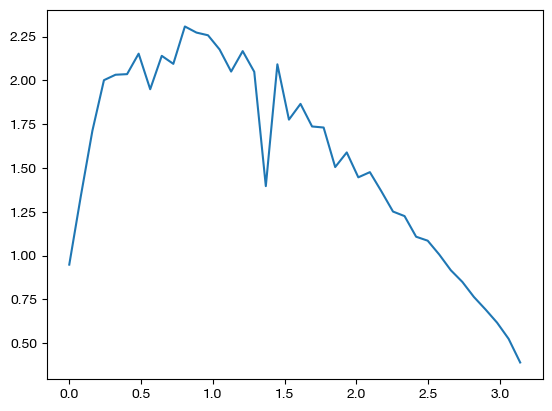

In [118]:
n = p.nPtn
phiPlt = np.linspace(0, np.pi, n)
plt.plot(phiPlt, valAvg)
plt.show()

#### Checks with analytical calculation

Reward function check

In [119]:
def intRwd(p):
    s = np.linspace(0, p.nSc*p.l, 100)
    t = s/p.vo
    fn = p.phiSt*p.a*(1 - np.exp(-t*p.vo/(p.phiSt*p.a)))
    # fn = p.phiSt*p.a*( np.exp(-s/(p.phiSt*p.a)) - np.exp(-p.nSc*p.l/(p.phiSt*p.a)))
    return t, fn

--- 0.054193973541259766 seconds ---


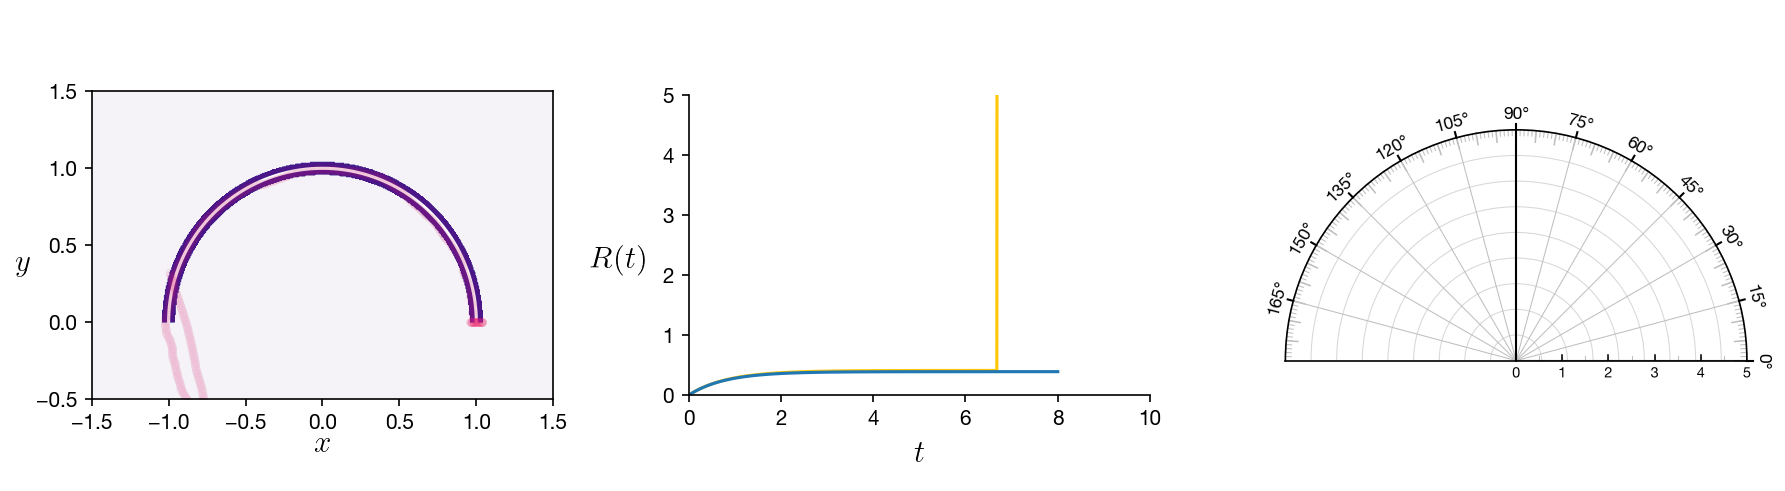

In [124]:
# 1-epoch run
import importlib
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
ag = agent(p)
eInd = 0
while eInd < 100:
    p = pR.params()
    start_time = time.time()
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
    p.nSc = 0.8*p.nSteps
    while ag.sInd <= p.nSteps:
        if ag.sInd < p.nSc:
            ag.intPolicy(p)
        elif ag.sInd == p.nSc:
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
        ag.sTrl += p.l
        ag.sInd += 1
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
    eInd += 1
    pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn, 10.)
print("--- %s seconds ---" % (time.time() - start_time))
s, fn = intRwd(p)
ax[1].plot(s, fn)
plt.show()